# Transfer learning with pretrained Keras models

Although Kernel resources were increased recently we still can not train useful CNNs without GPU. Fortunately prediction is much faster (<1s/image) making it possible to run meaningful experiments with Kaggle Kernels.

In [6]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import cv2
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

/home/elienonnon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

In [9]:
start = dt.datetime.now()

# Use Keras Pretrained Models dataset
Kernels can't use network connection to download pretrained keras model weights.
This dataset helps you to apply your favorite pretrained model in the Kaggle Kernel environment. 
You can find more details [here](https://www.kaggle.com/gaborfodor/keras-pretrained-models).

We have to copy the pretrained models to the cache directory (~/.keras/models) where keras is looking for them.

In [10]:
!ls keras-pretrained-models/

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Kuszma.JPG
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [11]:
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [12]:
!cp keras-pretrained-models/xception* ~/.keras/models/

In [13]:
!ls ~/.keras/models

xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


# Check the plant seedlings

In [14]:
!ls plant-seedlings-classification

ls: cannot access 'plant-seedlings-classification': No such file or directory


In [15]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [16]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = '.'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [17]:
sample_submission.head(2)

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet


In [18]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [19]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)
train.shape

,file,category_id,category
0,train/Black-grass/078eae073.png,0,Black-grass
1,train/Black-grass/e62aa6d6e.png,0,Black-grass


(4750, 3)

# Training sample

In [20]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(2)
train.shape

,file,category_id,category
0,train/Sugar beet/6d623072a.png,11,Sugar beet
1,train/Common wheat/9c8cf72ed.png,4,Common wheat


(2400, 3)

In [21]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)
test.shape

,filepath,file
0,test/f4234cf4f.png,f4234cf4f.png
1,test/1d321253f.png,1d321253f.png


(794, 2)

In [22]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [23]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    
    return image_sharp

def show_image(imageFile):
    image = imageFile #images_per_class["Maize"][2]
    image_mask = create_mask_for_plant(image)
    image_segmented = segment_plant(image)
    image_sharpen = sharpen_image(image_segmented)

    fig, axs = plt.subplots(1, 4, figsize=(10, 10))
    axs[0].imshow(image)
    axs[1].imshow(image_mask)
    axs[2].imshow(image_segmented)
    axs[3].imshow(image_sharpen)

# Example images

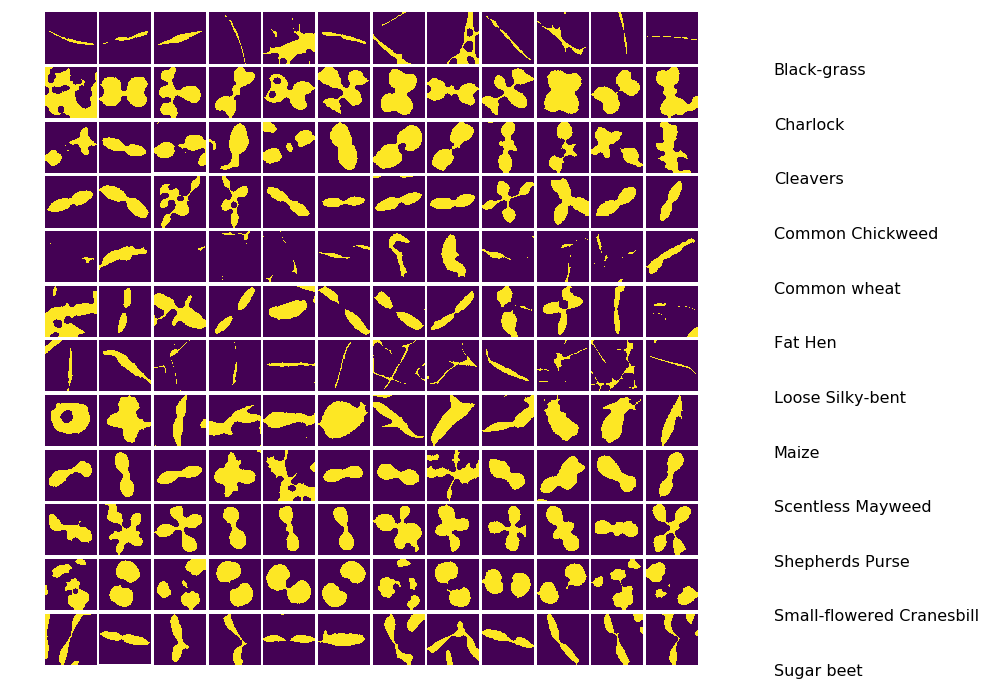

In [24]:
from PIL import Image
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0

for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = cv2.imread(filepath, cv2.IMREAD_COLOR)
        r = 100.0 / img.shape[1]
        dim = (100, int(img.shape[0] * r))
        # perform the actual resizing of the image and show it
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        #img = read_img(filepath, (224, 224))
        img = create_mask_for_plant(img)
        img = np.uint8(img)
        ax.imshow(img)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [25]:
img.shape

(100, 100)

# Validation split

In [26]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.9
valid_idx = rnd >= 0.9
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(2131, 269)

## Extract Xception bottleneck features

In [27]:
INPUT_SIZE = 300
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    r = 300.0 / img.shape[1]
    dim = (300, int(img.shape[0] * r))
    # perform the actual resizing of the image and show it
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    #img = read_img(filepath, (224, 224))
    img = create_mask_for_plant(img)
    img = np.uint8(img)
    x =img.copy()
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [00:32, 72.84it/s]

Train Images shape: (2400, 300, 300) size: 216,000,000


In [28]:
train_images = x_train.reshape((2400, 300 * 300))
#train_images = train_images.astype('float32') / 255

In [29]:
print('Train Images shape: {} size: {:,}'.format(train_images.shape, train_images.size))

Train Images shape: (2400, 90000) size: 216,000,000


In [30]:
train_labels.shape

NameError: name 'train_labels' is not defined

In [32]:
from keras.utils import to_categorical

train_labels = to_categorical(train['category_id'])
#test_labels = to_categorical(test['category_id'])

In [33]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(300 * 300,)))
network.add(layers.Dense(12, activation='softmax'))
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [34]:
network.fit(train_images, train_labels, epochs=20, batch_size=128)

Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor of shape [90000,512] and type float
	 [[Node: training/RMSprop/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [90000,512] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'training/RMSprop/zeros', defined at:
  File "/home/elienonnon/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/elienonnon/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/elienonnon/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/elienonnon/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/elienonnon/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-5d42a2b8732f>", line 1, in <module>
    network.fit(train_images, train_labels, epochs=20, batch_size=128)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/keras/models.py", line 963, in fit
    validation_steps=validation_steps)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1682, in fit
    self._make_train_function()
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 245, in get_updates
    accumulators = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 245, in <listcomp>
    accumulators = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 692, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1626, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2717, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/elienonnon/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [90000,512] and type float
	 [[Node: training/RMSprop/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [90000,512] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

## LogReg on Xception bottleneck features

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

In [ ]:
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

## Confusion matrix

In [ ]:
cnf_matrix = confusion_matrix(yv, valid_preds)

In [ ]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

In [ ]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show();

## Create submission

In [ ]:
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    r = 200.0 / img.shape[1]*1.
    z=int(img.shape[0] *r)
    if z!=200 :
        z=200
    dim = (200, z)
    # perform the actual resizing of the image and show it
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    #img = read_img(filepath, (224, 224))
    img = segment_plant(img)*1.
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

In [ ]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

In [ ]:
test['category_id'] = test_preds
test['species'] = [CATEGORIES[c] for c in test_preds]
test[['file', 'species']].to_csv('submission4.csv', index=False)

In [ ]:
end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))
print('We almost used the one hour time limit.')